<a id ='1.0'></a>
<p style="background-color:lightgreen; font-family:newtimeroman; font-size:150%; text-align:center">AC Required Operating Capacity</p>

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#### Loading and Visualizing data

In [125]:
col = ['Time','AC Primary Load','Grid Purchases','AC Operating Capacity','AC Required Operating Capacity']
df = pd.read_csv('DATA SET.csv')
cols = df.columns 
df = df[col]
df.set_index(pd.to_datetime(df['Time']), inplace=True)

In [126]:
mean_data = df.groupby(pd.Grouper(freq='1D')).mean()
data=pd.DataFrame(mean_data[col[4]]) # AC REquired Operating Capacity

#### Setting Data manipulation

In [127]:
#Feature Engineering
data['month'] = pd.DatetimeIndex(data.index).month

data.loc[data['month']==1, [col[4]]] *= 0.79
data.loc[data['month']==2, [col[4]]] *= 0.75
data.loc[data['month']==3, [col[4]]] *= 0.75
data.loc[data['month']==4, [col[4]]] *= 0.75
data.loc[data['month']==5, [col[4]]] *= 0.76
data.loc[data['month']==6, [col[4]]] *= 0.78
data.loc[data['month']==7, [col[4]]] *= 0.85
data.loc[data['month']==8, [col[4]]] *= 0.81
data.loc[data['month']==9, [col[4]]] *= 0.77
data.loc[data['month']==10, [col[4]]] *= 0.75
data.loc[data['month']==11, [col[4]]] *= 0.74
data.loc[data['month']==12, [col[4]]] *= 0.83

<AxesSubplot:title={'center':'AC Required Operating Capacity'}, xlabel='Time'>

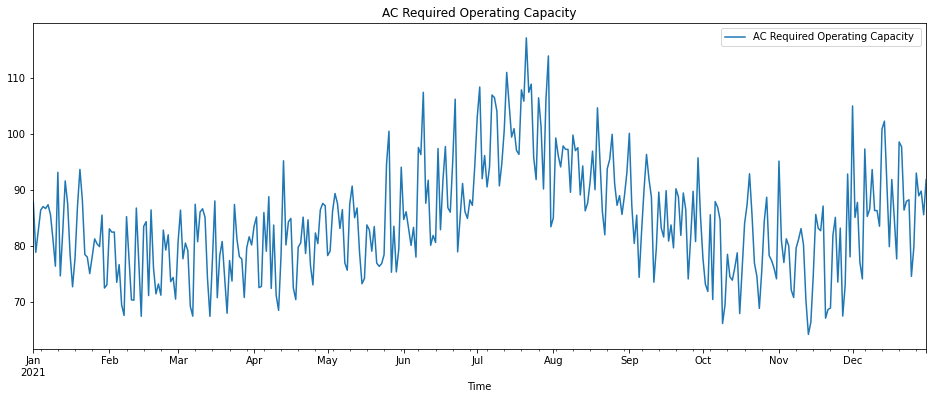

In [131]:
data = data[col[4]]
data.plot(figsize=(16,6), title='AC Required Operating Capacity', legend=True, label='AC Required Operating Capacity ')

#### Is the data stationary?

In [132]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(data)
#Data is Not stationary...

(0.6895071098021017, True)

#### Dickey-Fuller test

In [133]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(data)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")
#Since data is not stationary, we may need SARIMA and not just ARIMA

pvalue =  0.34040646214789044  if above 0.05, data is not stationary


#### Plot trend, seasonal and residuals

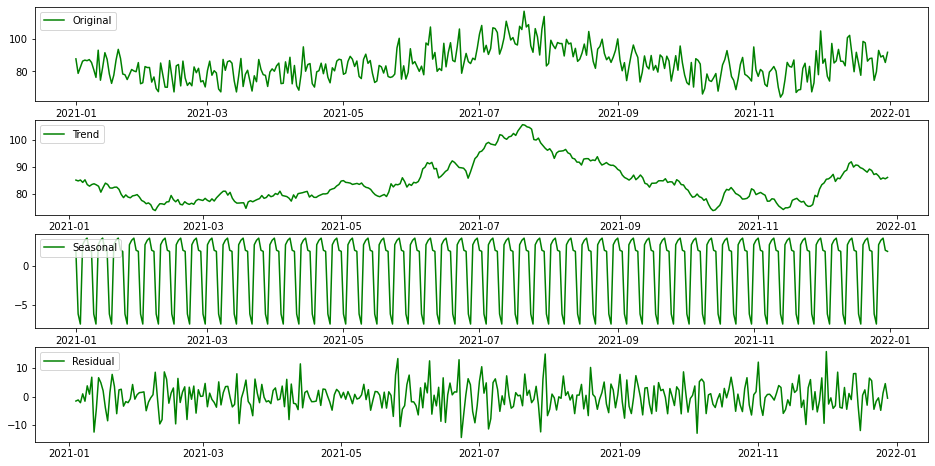

In [134]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(data,  
                            model ='additive')

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

plt.figure(figsize=(16,8))
plt.subplot(411)
plt.plot(data, label='Original', color='green')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='green')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='green')
plt.legend(loc='upper left')
plt.show()

#### Find Best ARIMA/SARIMAX

In [ ]:
#We can go through the exercise of making the data stationary and performing ARIMA
#Or let auto_arima provide the best model (e.g. SARIMA) and parameters. 
#Auto arima suggests best model and parameters based on 
#AIC metric (relative quality of statistical models)

from pmdarima.arima import auto_arima
#Autoarima gives us bet model suited for the data
# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components
arima_model = auto_arima(data, start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50) 

In [136]:
# To print the summary 
print(arima_model.summary() ) #Note down the Model and details.

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  365
Model:             SARIMAX(1, 1, 2)x(4, 1, 2, 12)   Log Likelihood               -1208.647
Date:                            Sat, 09 Oct 2021   AIC                           2437.295
Time:                                    02:34:23   BIC                           2475.931
Sample:                                         0   HQIC                          2452.670
                                            - 365                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7651      0.173     -4.426      0.000      -1.104      -0.426
ma.L1         -0.0163      0.156   

<a id ='2.0'></a>
<p style="background-color:lightgreen; font-family:newtimeroman; font-size:150%; text-align:center">(A) Predicting</p>

In [137]:
#Split data into train and test
size = int(len(data) * 0.66)
X_train, X_test = data[0:size], data[size:len(data)]

#### Model fitting

In [138]:
# Fit a  SARIMAX(1, 1, 2)x(4, 1, 2, 12)
from statsmodels.tsa.statespace.sarimax import SARIMAX 
model = SARIMAX(X_train,  
                order = (1, 1, 2),  
                seasonal_order =(4, 1, 2, 12))  #change seasonal MA to 0 for testing better results
  
result = model.fit() 
#result.summary() 

#### Train prediction

In [139]:
start_index = 0
end_index = len(X_train)-1
train_prediction = result.predict(start_index, end_index) 

#### Test Prediction

In [140]:
#Prediction
start_index = len(X_train)
end_index = len(data)-1
prediction = result.predict(start_index, end_index).rename('AC Required Operating Capacity')

<AxesSubplot:title={'center':'AC Required Operating Capacity Test Vs. Predicted'}, xlabel='Time'>

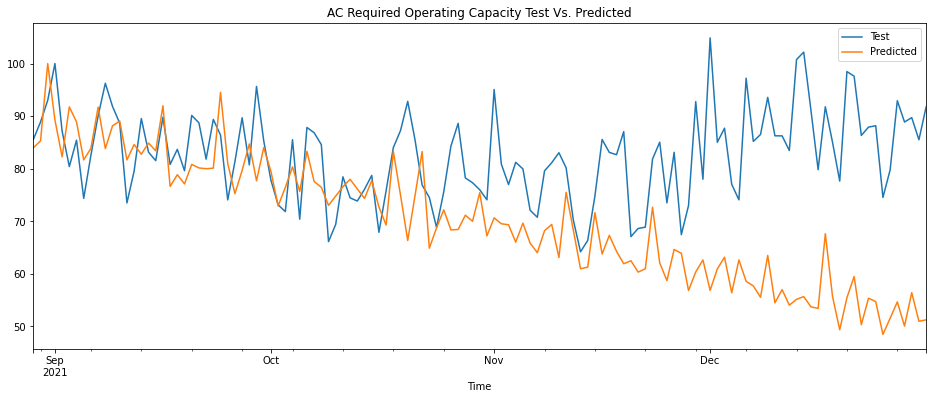

In [141]:
# plot predictions and actual values 
X_test.plot(figsize=(16,6), label='Test', title = 'AC Required Operating Capacity Test Vs. Predicted', legend = True) 
prediction.plot(label = 'Predicted', legend = True) 

#### How valid is our model?

In [142]:
import math
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(X_train, train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(X_test, prediction))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 9.57 RMSE
Test Score: 19.02 RMSE


<a id ='3.0'></a>
<p style="background-color:lightgreen; font-family:newtimeroman; font-size:150%; text-align:center">(B) Forecasting</p>

In [227]:
#Forecast.. re-train on the entire dataset before forecasting 
model = SARIMAX(data,  
                order = (1, 0, 1),  
                seasonal_order =(4, 1, 0, 12))  #change seasonal MA to 0 for testing better results
  
result = model.fit()

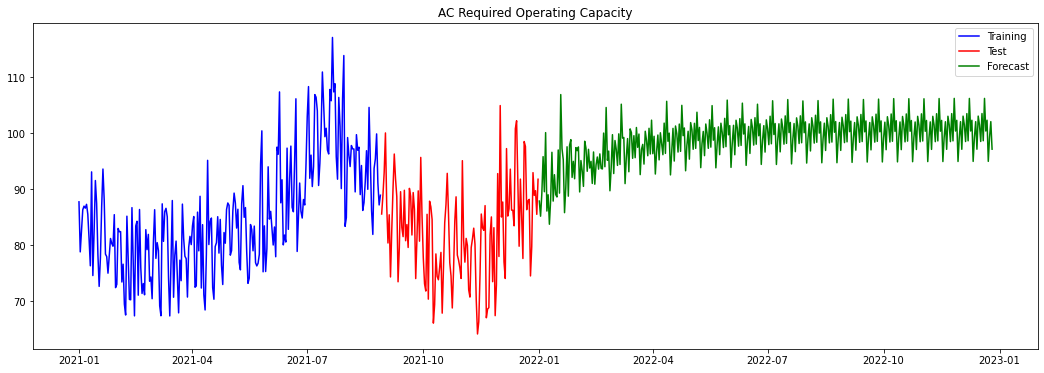

In [228]:
# Forecast for the next 1 years
forecast = result.predict(start = len(data),  
                          end = (len(data)-1) + 30 * 12,  
                          typ = 'levels').rename('Forecast') 
  
plt.figure(figsize=(18,6))
plt.title('AC Required Operating Capacity')
plt.plot(X_train, label='Training', color='blue')
plt.plot(X_test, label='Test', color='red')
plt.plot(forecast, label='Forecast', color='green')
plt.legend(loc='best')
plt.show()